In [1]:
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter("ignore")
train = pd.read_csv('../input/tabular-playground-series-feb-2022/train.csv')
test = pd.read_csv('../input/tabular-playground-series-feb-2022/test.csv')
sub = pd.read_csv('../input/tabular-playground-series-feb-2022/sample_submission.csv')

display(train.head())
display(sub.head())

,row_id,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,...,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0,target
0,0,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,...,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Streptococcus_pyogenes
1,1,-9.536743e-07,-0.000010,-0.000043,0.000886,-0.000200,0.000760,-0.000200,-0.000114,-0.000043,...,-0.000086,-0.000043,0.000914,0.000914,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Salmonella_enterica
2,2,-9.536743e-07,-0.000002,0.000007,0.000129,0.000268,0.000270,0.000243,0.000125,0.000001,...,0.000084,0.000048,0.000081,0.000106,0.000072,0.000010,0.000008,0.000019,1.046326e-06,Salmonella_enterica
3,3,4.632568e-08,-0.000006,0.000012,0.000245,0.000492,0.000522,0.000396,0.000197,-0.000003,...,0.000151,0.000100,0.000180,0.000202,0.000153,0.000021,0.000015,0.000046,-9.536743e-07,Salmonella_enterica
4,4,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,...,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Enterococcus_hirae


,row_id,target
0,200000,Streptococcus_pneumoniae
1,200001,Streptococcus_pneumoniae
2,200002,Streptococcus_pneumoniae
3,200003,Streptococcus_pneumoniae
4,200004,Streptococcus_pneumoniae


In [2]:
train.drop_duplicates(keep='first', inplace=True)
train.shape

(200000, 288)

# Reduce Memory Usage

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

In [4]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 222.02 Mb (49.7% reduction)
Mem. usage decreased to 109.48 Mb (50.0% reduction)


# Modeling

In [5]:
%%capture
!pip install pycaret[full]

In [6]:
from pycaret.classification import *

numeric_cols = train.select_dtypes(include=np.number).columns.tolist()
ignore_cols = ['row_id']

clf = setup(data=train,
            target='target',
            #normalize = True, #normalisation helps some algorithms
            #normalize_method = 'robust', #resilient to outliers
            #transformation = True, #applies transformation to target column
            #transformation_method = 'quantile',
            data_split_shuffle = False, #so that we do not use "future" observations to predict "past" observations
            create_clusters = True,
            remove_outliers = True,
            #feature_interaction = True,
            numeric_features = numeric_cols,
            ignore_features = ignore_cols,
            session_id = 42,
            use_gpu = False,
            silent = True,
            fold = 10,
            n_jobs = -1)

,Description,Value
0,session_id,42
1,Target,target
2,Target Type,Multiclass
3,Label Encoded,"Bacteroides_fragilis: 0, Campylobacter_jejuni: 1, Enterococcus_hirae: 2, Escherichia_coli: 3, Escherichia_fergusonii: 4, Klebsiella_pneumoniae: 5, Salmonella_enterica: 6, Staphylococcus_aureus: 7, Streptococcus_pneumoniae: 8, Streptococcus_pyogenes: 9"
4,Original Data,"(200000, 288)"
5,Missing Values,False
6,Numeric Features,286
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


## Blending

In [7]:
#N = 2
#include = ['nb', 'ridge', 'rf', 'et', 'dt', 'lr', 'qda', 'lda', 'lightgbm']
#include = ['rf', 'et']
#top = compare_models(sort = 'Accuracy', n_select = N, include = include)

In [8]:
#tuned_top = [tune_model(i, optimize = 'accuracy', choose_better=True, n_iter=100) for i in top]

In [9]:
#blend = blend_models(top, optimize='Accuracy')
#predict_model(blend);

In [10]:
#final_blend = finalize_model(blend)

In [11]:
#plot_model(final_blend, plot='error')

In [12]:
#plot_model(final_blend, plot = 'confusion_matrix')

## Ensembling

In [13]:
#include = ['nb', 'ridge', 'rf', 'et', 'dt', 'lr', 'qda', 'lda', 'lightgbm']
#include = ['rf', 'et']
#best = compare_models(sort = 'Accuracy', include = include)

In [14]:
#tuned = tune_model(best, optimize = 'accuracy', choose_better=True, n_iter=100)

In [15]:
#ensemble = ensemble_model(best, method='Bagging')
#predict_model(ensemble);

In [16]:
#final_ensemble = finalize_model(ensemble)

In [17]:
#plot_model(final_ensemble, plot='error')

In [18]:
#plot_model(final_ensemble, plot = 'confusion_matrix')

## Stacking

In [19]:
N = 2
#include = ['nb', 'ridge', 'rf', 'et', 'dt', 'lr', 'qda', 'lda', 'lightgbm']
include = ['rf', 'et']
top = compare_models(sort = 'Accuracy', n_select = N, include = include)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9890,0.9999,0.9891,0.9890,0.9890,0.9878,0.9878,24.8450
rf,Random Forest Classifier,0.9888,0.9999,0.9889,0.9888,0.9888,0.9876,0.9876,45.0920


In [20]:
#tuned_top = [tune_model(i, optimize = 'accuracy', choose_better=True, n_iter=100) for i in top]

In [21]:
stack = stack_models(top, optimize='Accuracy')
predict_model(stack);

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9919,1.0000,0.9919,0.9919,0.9919,0.9910,0.9910
1,0.9915,1.0000,0.9915,0.9915,0.9915,0.9906,0.9906
2,0.9916,1.0000,0.9916,0.9916,0.9916,0.9906,0.9906
3,0.9893,1.0000,0.9894,0.9893,0.9893,0.9881,0.9881
4,0.9900,1.0000,0.9900,0.9900,0.9900,0.9889,0.9889
5,0.9917,1.0000,0.9917,0.9917,0.9917,0.9907,0.9907
6,0.9892,0.9999,0.9893,0.9893,0.9892,0.9881,0.9881
7,0.9915,1.0000,0.9915,0.9915,0.9915,0.9906,0.9906
8,0.9883,0.9999,0.9884,0.9884,0.9883,0.9870,0.9871
9,0.9907,1.0000,0.9907,0.9907,0.9907,0.9896,0.9896


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9839,0.9999,0.9839,0.9840,0.9839,0.9821,0.9822


In [22]:
final_stack = finalize_model(stack)

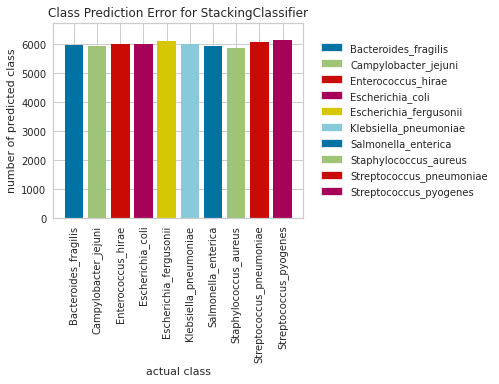

In [23]:
plot_model(final_stack, plot='error')

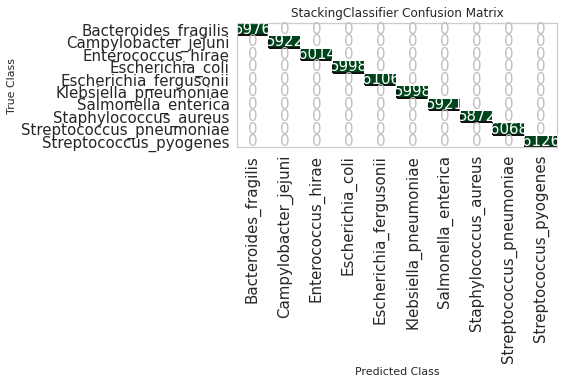

In [24]:
plot_model(final_stack, plot = 'confusion_matrix')

# Predictions

In [25]:
import gc
gc.collect()
unseen_predictions = predict_model(final_stack, data=test)
unseen_predictions.head()

,row_id,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,...,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0,Label,Score
0,200000,-9.536743e-07,-0.000002,-9.153442e-07,0.000024,0.000034,-0.000002,0.000021,0.000024,-0.000009,...,0.000055,0.000108,0.000090,0.000059,0.000010,0.000006,0.000027,4.632568e-08,Escherichia_fergusonii,1.0000
1,200001,-9.536743e-07,-0.000010,-4.291534e-05,-0.000114,0.001800,-0.000240,0.001800,-0.000114,0.000957,...,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Salmonella_enterica,0.9532
2,200002,4.632568e-08,0.000003,8.465576e-08,-0.000014,0.000007,-0.000005,-0.000004,0.000003,0.000004,...,0.000084,0.000111,0.000117,0.000070,0.000020,0.000030,0.000021,4.632568e-08,Enterococcus_hirae,1.0000
3,200003,-9.536743e-07,-0.000008,8.084656e-06,0.000216,0.000420,0.000514,0.000452,0.000187,-0.000005,...,0.000098,0.000175,0.000217,0.000150,0.000018,0.000016,0.000051,-9.536743e-07,Salmonella_enterica,1.0000
4,200004,-9.536743e-07,-0.000010,-4.291534e-05,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,...,-0.000043,-0.000086,0.000914,-0.000043,-0.000010,-0.000010,0.000990,-9.536743e-07,Staphylococcus_aureus,0.9951


In [26]:
assert(len(test.index)==len(unseen_predictions))
sub = pd.DataFrame(list(zip(sub.row_id, unseen_predictions.Label)),columns = ['row_id', 'target'])
sub.to_csv('submission_stack.csv', index = False)
sub.head()

,row_id,target
0,200000,Escherichia_fergusonii
1,200001,Salmonella_enterica
2,200002,Enterococcus_hirae
3,200003,Salmonella_enterica
4,200004,Staphylococcus_aureus


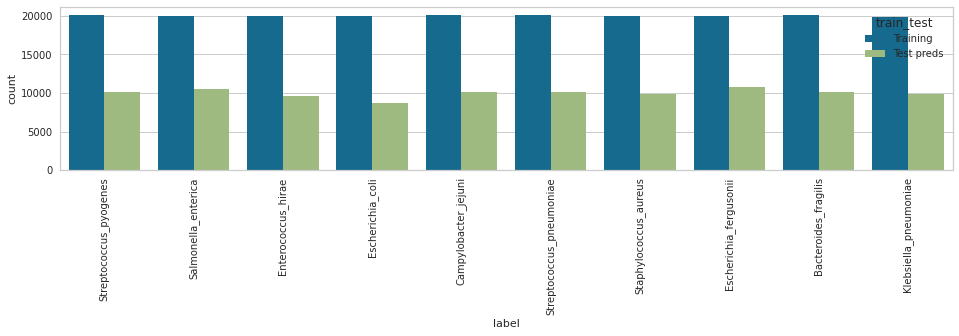

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

train_test_preds = pd.DataFrame()
train_test_preds['label'] = list(train['target']) + list(unseen_predictions['Label'])
train_test_preds['train_test'] = 'Test preds'
train_test_preds.loc[0:len(train[['target']]), 'train_test'] = 'Training'

fig, ax = plt.subplots(figsize=(16,3))
sns.countplot(data=train_test_preds, x='label', hue='train_test', ax=ax)
plt.xticks(rotation=90)
plt.show()